In [38]:
import h5py
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch.nn as nn
import torch
import umap
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# Sample from Train Data
It's necessary to take a sample here, because there is so much data. Even sampling just 50 individual time series, we end up with nearly 500 rows of data.  

In [2]:
def sample_from_index(hdf5_file, index_file, num_series=5):
    """
    Samples full time series from an HDF5 file using precomputed indices in an index CSV.

    Parameters:
        hdf5_file (str): Path to the main dataset HDF5 file.
        index_file (str): Path to the CSV index file storing time series indices.
        num_series (int): Number of full time series to sample.

    Returns:
        sampled_X (np.array): Sampled feature data.
        sampled_y (np.array): Corresponding labels.
    """
    index_df = pd.read_csv(index_file)

    # randomly sample num_series time series
    num_series = min(num_series, len(index_df))
    sampled_series = index_df.sample(num_series).sort_values(by=["start_idx"])

    sampled_rows = []
    for _, row in sampled_series.iterrows():
        sampled_rows.extend(range(row["start_idx"], row["stop_idx"] + 1))

    # load only the required rows
    with h5py.File(hdf5_file, "r") as infile:
        columns = [col.decode("utf-8") for col in infile.attrs["columns"]]
        sampled_X = infile["X"][sampled_rows]
        sampled_y = infile["y"][sampled_rows]

    print(f"Sampled {len(sampled_X)} rows covering {num_series} full time series.")
    return sampled_X, sampled_y, columns


In [4]:
X, y, cols = sample_from_index("../engine_train.h5", "../engine_index.csv", num_series=50)

Sampled 437880 rows covering 50 full time series.


# Basic EDA
#### Start with basic investigation of the data

In [5]:
y = y.reshape((y.shape[0], 1))
df = pd.DataFrame(np.concatenate((X, y), axis=1), columns=cols+["RUL"])
df.head()

alt      Mach       TRA          T2         T24          T30  \
0  18796.0  0.590940  47.81216  483.183533  549.561462  1258.865601   
1  18787.0  0.590877  47.81216  483.211548  549.592224  1258.930542   
2  18781.0  0.590877  47.81216  483.234711  549.619446  1258.998169   
3  18772.0  0.590688  47.81216  483.248322  549.636902  1259.036865   
4  18765.0  0.590625  47.81216  483.268585  549.659241  1259.098267   

           T48          T50        P15        P2  ...  HPC_flow_mod  \
0  1517.407837  1060.331543  11.016341  8.975883  ...           0.0   
1  1517.524780  1060.431641  11.019933  8.978842  ...           0.0   
2  1517.590332  1060.476440  11.022792  8.981119  ...           0.0   
3  1517.625977  1060.516968  11.025320  8.983079  ...           0.0   
4  1517.733154  1060.606689  11.028066  8.985291  ...           0.0   

   HPT_eff_mod  HPT_flow_mod  LPT_eff_mod  LPT_flow_mod  unit  cycle   Fc  \
0    -0.004576           0.0          0.0           0.0   2.0   52.0  3.0   
1    -0.004576           0.0          0.0           0.0   2.0   52.0  3.0   
2    -0.004576           0.0          0.0           0.0   2.0   52.0  3.0   
3    -0.004576           0.0          0.0           0.0   2.0   52.0  3.0   
4    -0.004576           0.0          0.0           0.0   2.0   52.0  3.0   

    hs   RUL  
0  0.0  23.0  
1  0.0  23.0  
2  0.0  23.0  
3  0.0  23.0  
4  0.0  23.0  

[5 rows x 47 columns]

#### Looking into the identity of One Cycle 

In [31]:
one_cycle = df[(df['unit'] == 2.0) & (df['cycle'] == 52.0)]
print('Number of Records for one cycle: ', len(one_cycle))
      

row_diff = one_cycle.iloc[0] - one_cycle.iloc[-1]
print(row_diff)

Number of Records for one cycle:  3549
alt             0.525771
Mach            0.619200
TRA             0.195994
T2             -0.365071
T24            -0.213879
T30            -0.124614
T48            -0.067432
T50            -0.233127
P15            -0.433088
P2             -0.504582
P21            -0.433088
P24            -0.357015
Ps30           -0.230610
P40            -0.232856
P50            -0.527297
Nf              0.116588
Nc             -0.120785
Wf             -0.171007
T40            -0.066205
P30            -0.232856
P45            -0.224366
W21            -0.259683
W22            -0.271194
W25            -0.271168
W31            -0.271168
W32            -0.271168
W48            -0.268691
W50            -0.268854
SmFan           0.565667
SmLPC          -0.235530
SmHPC           0.015244
phi            -0.016745
fan_eff_mod     0.000000
fan_flow_mod    0.000000
LPC_eff_mod     0.000000
LPC_flow_mod    0.000000
HPC_eff_mod     0.000000
HPC_flow_mod    0.000000
HPT_eff_mod

<Figure size 640x480 with 0 Axes>

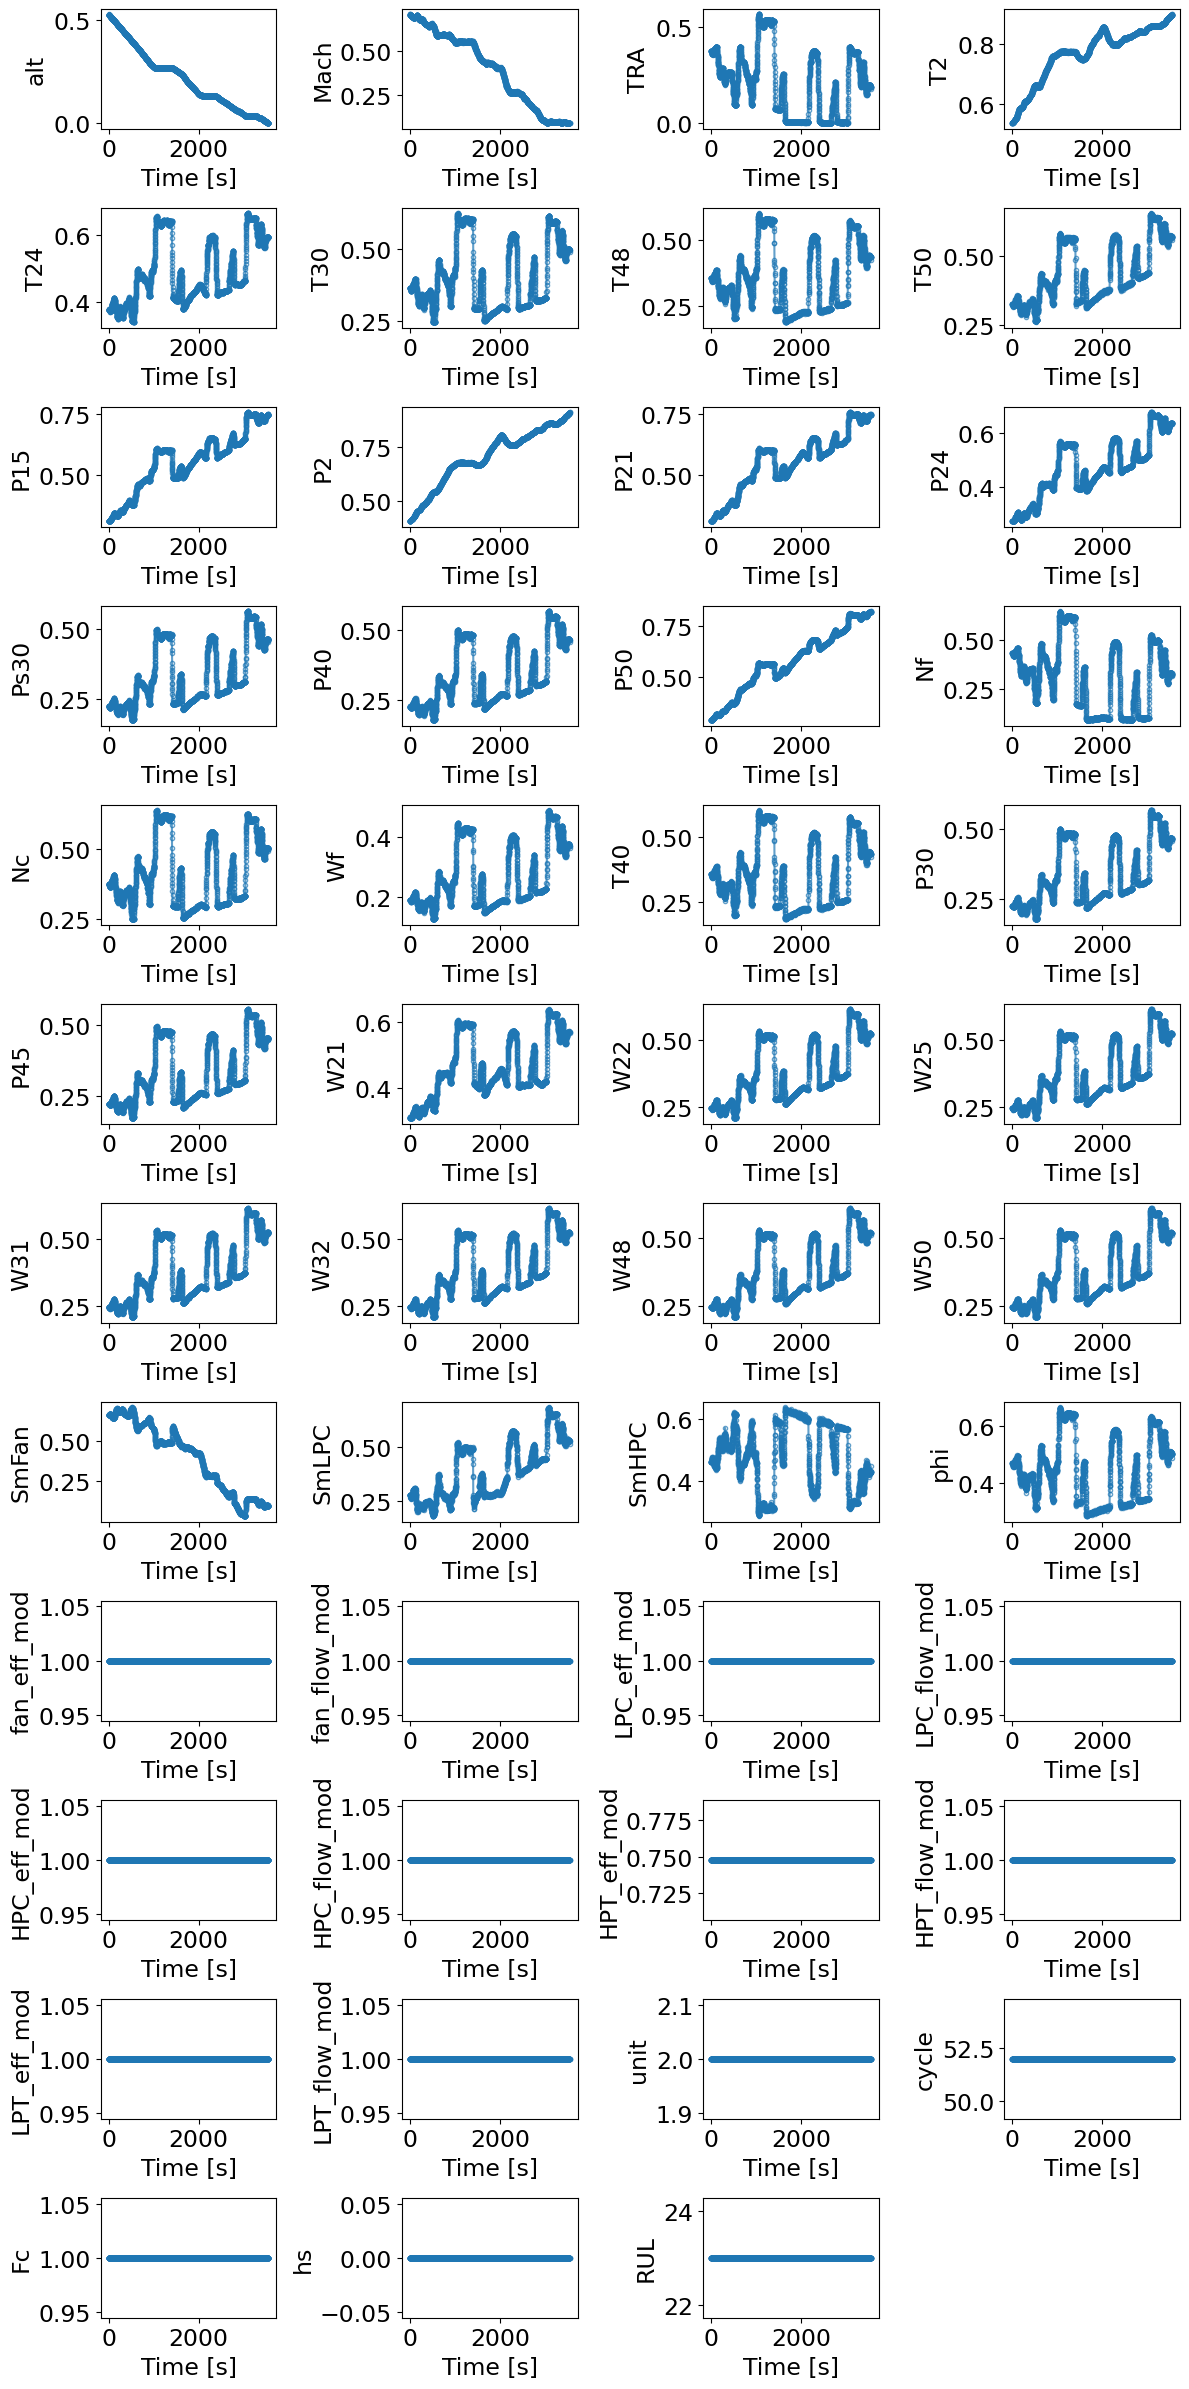

In [39]:
def plot_df_single_color(data, variables, labels, size=12, labelsize=17, name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)    
    fig  = plt.figure(figsize=(size,max(size,rows*2))) 
    
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        ax.plot(data[variables[n]], marker='.', markerfacecolor='none', alpha = 0.7)
        ax.tick_params(axis='x', labelsize=labelsize)
        ax.tick_params(axis='y', labelsize=labelsize)
        plt.ylabel(labels[n], fontsize=labelsize)
        plt.xlabel('Time [s]', fontsize=labelsize)
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()


plotting_vars = list(one_cycle.columns)
    
one_cycle.reset_index(inplace=True, drop=True)
plot_df_single_color(one_cycle, plotting_vars, plotting_vars)

In [40]:
def plot_kde(leg, variables, labels, size, units, df_W, df_A, labelsize=17, name=None):
    """
    """
    plt.clf()
       
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs = gridspec.GridSpec(rows, cols)
    
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    fig = plt.figure(figsize=(size,max(size,rows*2)))       

    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for k, elem in enumerate(units):
            sns.kdeplot(df_W.loc[df_A['unit'] == elem, variables[n]],
                        color=color_dic_unit[leg[k]], shade=True, gridsize=100)  
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
        
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))        
        plt.xlabel(labels[n], fontsize=labelsize)
        plt.ylabel('Density [-]', fontsize=labelsize)
        if n==0:
            plt.legend(leg, fontsize=labelsize-4, loc=0)
        else:
            plt.legend(leg, fontsize=labelsize-4, loc=2)
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)    
    plt.show()
    plt.close()

In [43]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<Figure size 640x480 with 0 Axes>

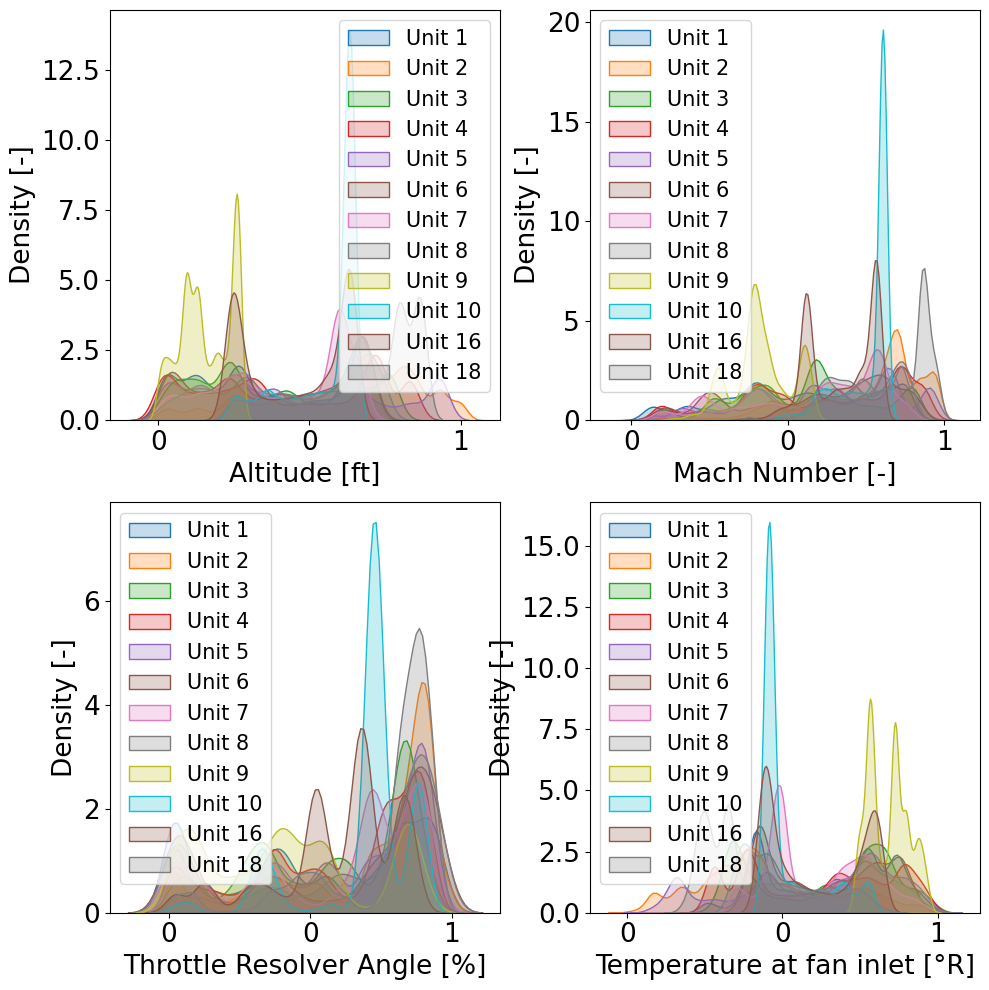

In [44]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

units = list(np.unique(df['unit']))
leg = ['Unit ' + str(int(u)) for u in units]

plot_kde(leg, variables, labels, size, units, df[['alt', 'Mach', 'TRA', 'T2']], df[['unit', 'cycle', 'Fc', 'hs', 'RUL']], labelsize=19, name='kde_DS02.png')

In [6]:
# standardize the data
scaler = MinMaxScaler()
cols_to_scale = [col for col in cols if col not in ["unit", "cycle"]]
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437880 entries, 0 to 437879
Data columns (total 47 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   alt           437880 non-null  float32
 1   Mach          437880 non-null  float32
 2   TRA           437880 non-null  float32
 3   T2            437880 non-null  float32
 4   T24           437880 non-null  float32
 5   T30           437880 non-null  float32
 6   T48           437880 non-null  float32
 7   T50           437880 non-null  float32
 8   P15           437880 non-null  float32
 9   P2            437880 non-null  float32
 10  P21           437880 non-null  float32
 11  P24           437880 non-null  float32
 12  Ps30          437880 non-null  float32
 13  P40           437880 non-null  float32
 14  P50           437880 non-null  float32
 15  Nf            437880 non-null  float32
 16  Nc            437880 non-null  float32
 17  Wf            437880 non-null  float32
 18  T40 

In [14]:
df.describe()

alt           Mach            TRA             T2  \
count  437880.000000  437880.000000  437880.000000  437880.000000   
mean        0.492185       0.657304       0.630610       0.553562   
std         0.272887       0.229349       0.297647       0.230505   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.254378       0.480492       0.396280       0.373893   
50%         0.541719       0.707815       0.756795       0.519372   
75%         0.699208       0.844062       0.878398       0.766162   
max         1.000000       1.000000       1.000000       1.000000   

                 T24            T30            T48            T50  \
count  437880.000000  437880.000000  437880.000000  437880.000000   
mean        0.500713       0.527827       0.530463       0.477040   
std         0.164492       0.162613       0.173989       0.154734   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.387841       0.421106       0.420699       0.376431   
50%         0.474684       0.518435       0.545751       0.443744   
75%         0.605878       0.624574       0.638077       0.572481   
max         1.000000       1.000000       1.000000       1.000000   

                 P15             P2  ...   HPC_flow_mod    HPT_eff_mod  \
count  437880.000000  437880.000000  ...  437880.000000  437880.000000   
mean        0.402935       0.455984  ...       0.881390       0.864340   
std         0.221255       0.253431  ...       0.271337       0.221828   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.227510       0.252487  ...       0.935744       0.821824   
50%         0.350452       0.389959  ...       1.000000       0.950189   
75%         0.586455       0.677566  ...       1.000000       1.000000   
max         1.000000       1.000000  ...       1.000000       1.000000   

        HPT_flow_mod    LPT_eff_mod   LPT_flow_mod           unit  \
count  437880.000000  437880.000000  437880.000000  437880.000000   
mean        0.938465       0.929017       0.889431       5.272634   
std         0.208703       0.163597       0.198686       4.675808   
min         0.000000       0.000000       0.000000       1.000000   
25%         1.000000       0.920530       0.856460       2.000000   
50%         1.000000       1.000000       1.000000       4.000000   
75%         1.000000       1.000000       1.000000       6.000000   
max         1.000000       1.000000       1.000000      18.000000   

               cycle             Fc             hs            RUL  
count  437880.000000  437880.000000  437880.000000  437880.000000  
mean       40.595055       0.740553       0.255552      37.612144  
std        24.371035       0.355398       0.436087      27.210051  
min         1.000000       0.000000       0.000000       0.000000  
25%        18.000000       0.500000       0.000000      16.000000  
50%        43.000000       1.000000       0.000000      33.000000  
75%        60.000000       1.000000       1.000000      51.000000  
max        85.000000       1.000000       1.000000      98.000000  

[8 rows x 47 columns]

#### Check for and possibly handle missing data
There is no missing data.

In [9]:
df.isnull().sum()

alt             0
Mach            0
TRA             0
T2              0
T24             0
T30             0
T48             0
T50             0
P15             0
P2              0
P21             0
P24             0
Ps30            0
P40             0
P50             0
Nf              0
Nc              0
Wf              0
T40             0
P30             0
P45             0
W21             0
W22             0
W25             0
W31             0
W32             0
W48             0
W50             0
SmFan           0
SmLPC           0
SmHPC           0
phi             0
fan_eff_mod     0
fan_flow_mod    0
LPC_eff_mod     0
LPC_flow_mod    0
HPC_eff_mod     0
HPC_flow_mod    0
HPT_eff_mod     0
HPT_flow_mod    0
LPT_eff_mod     0
LPT_flow_mod    0
unit            0
cycle           0
Fc              0
hs              0
RUL             0
dtype: int64

#### RUL Distribution and Failure Trends
It appears that engines that are unhealthy tend to have less remaining useful life, as would be expected. 

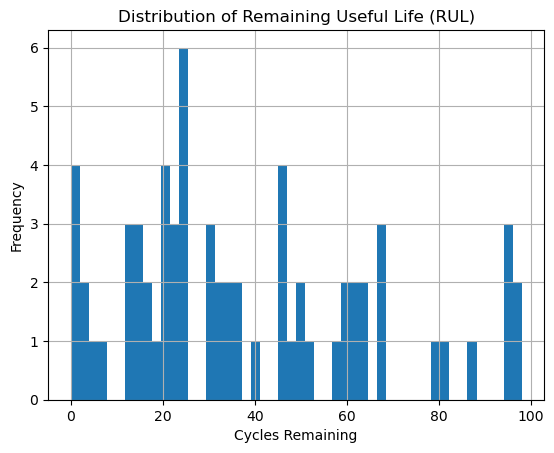

In [10]:
# groupby to avoid double counting for multiple entries per cycle (show distribution across all cycles weighted evenly) 
df.groupby(['unit','cycle', 'RUL']).size().reset_index().rename(columns={0:'count'})["RUL"].hist(bins=50)
#df["RUL"].hist(bins=50)
plt.title("Distribution of Remaining Useful Life (RUL)")
plt.xlabel("Cycles Remaining")
plt.ylabel("Frequency")
plt.show()

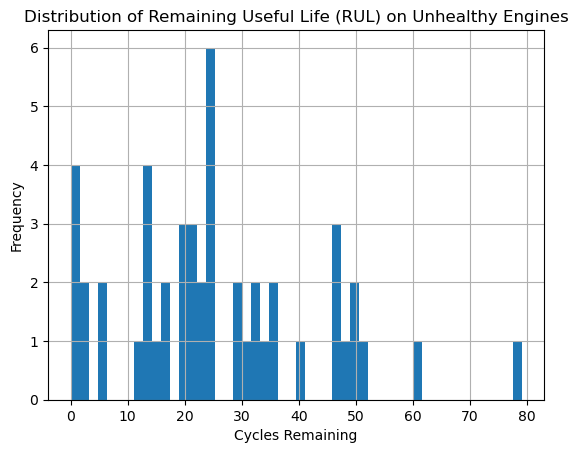

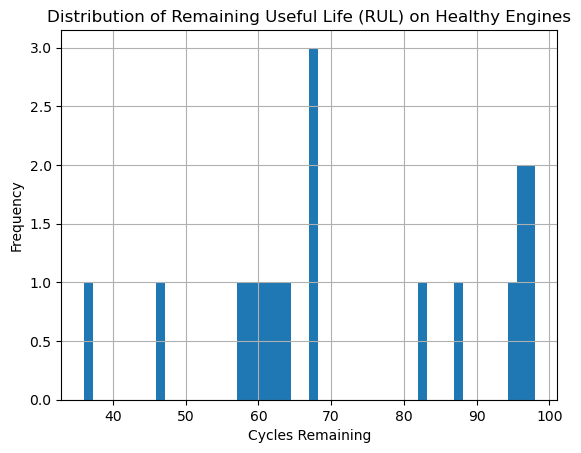

In [11]:
bad_engine = df[df["hs"]==0]
good_engine = df[df["hs"]==1]
bad_engine.groupby(['unit','cycle', 'RUL']).size().reset_index().rename(columns={0:'count'})["RUL"].hist(bins=50)
plt.title("Distribution of Remaining Useful Life (RUL) on Unhealthy Engines")
plt.xlabel("Cycles Remaining")
plt.ylabel("Frequency")
plt.show()
good_engine.groupby(['unit','cycle', 'RUL']).size().reset_index().rename(columns={0:'count'})["RUL"].hist(bins=50)
plt.title("Distribution of Remaining Useful Life (RUL) on Healthy Engines")
plt.xlabel("Cycles Remaining")
plt.ylabel("Frequency")
plt.show()

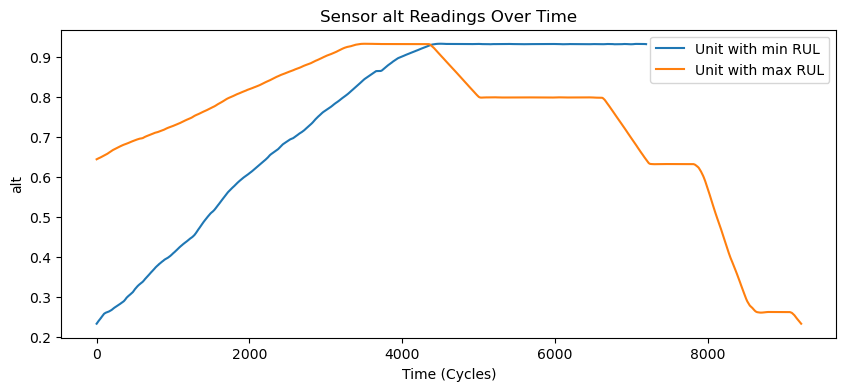

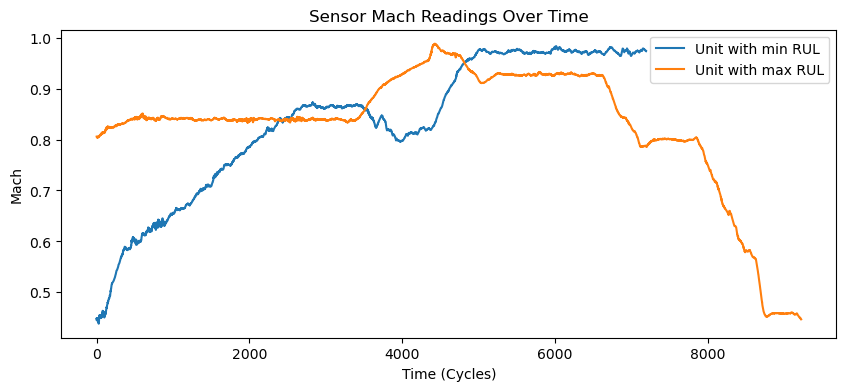

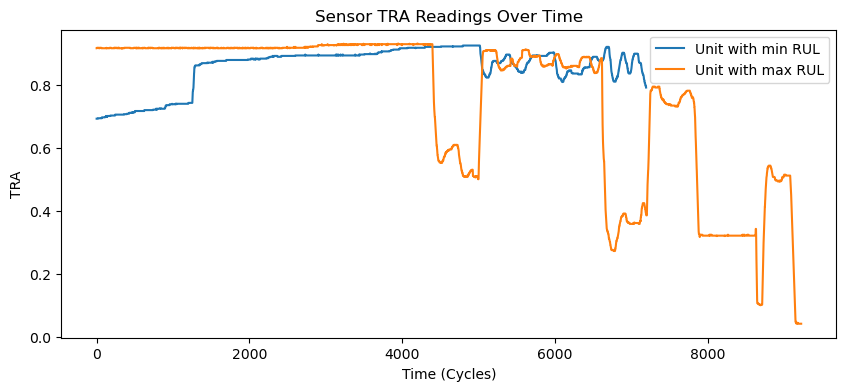

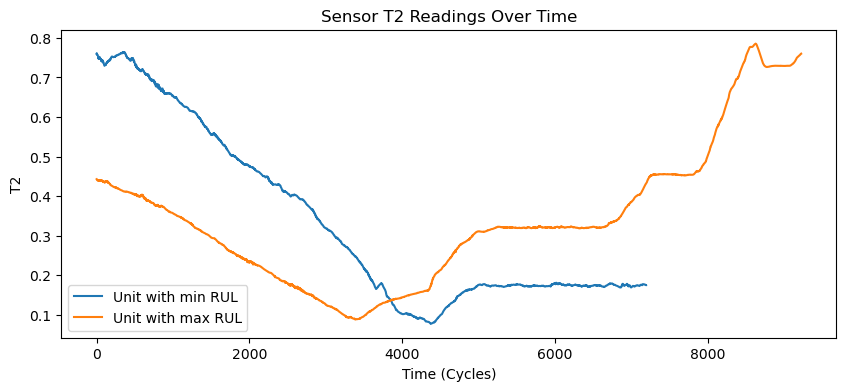

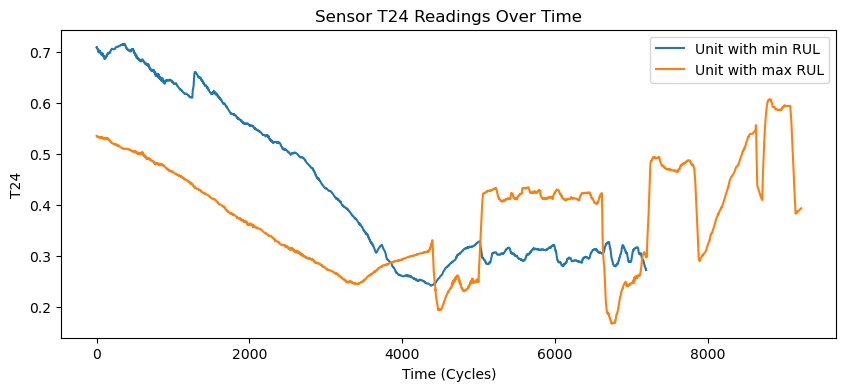

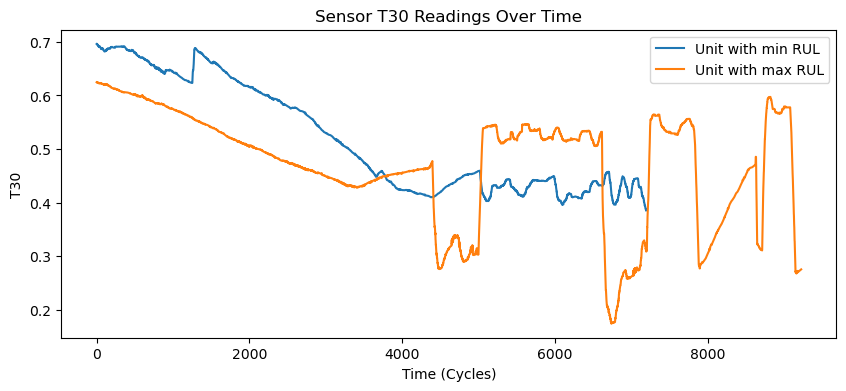

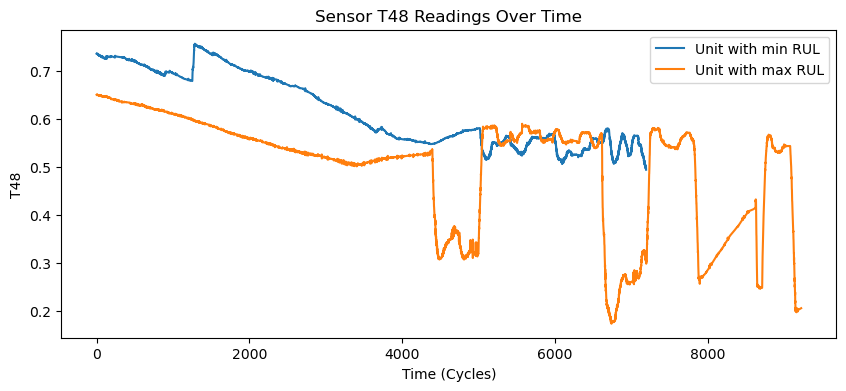

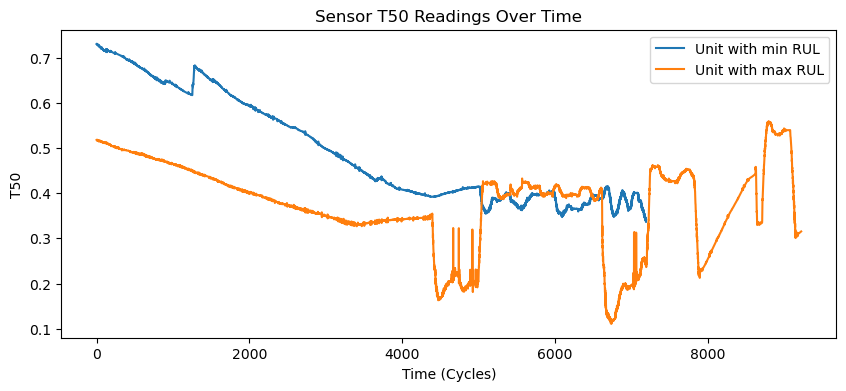

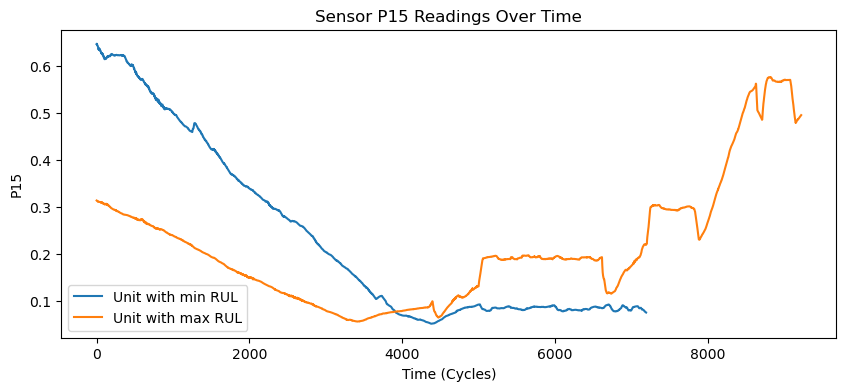

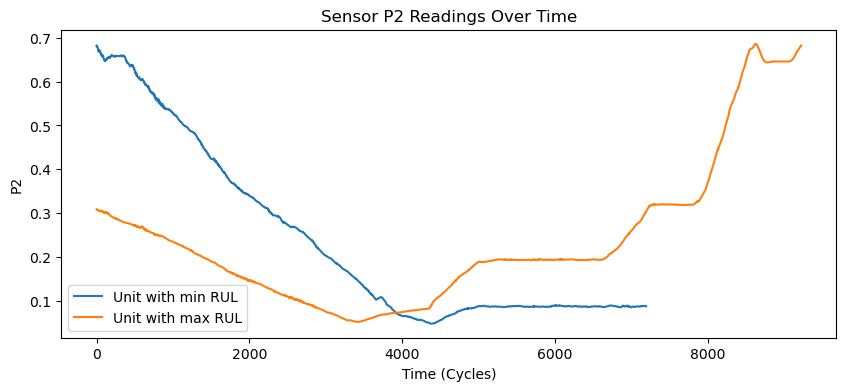

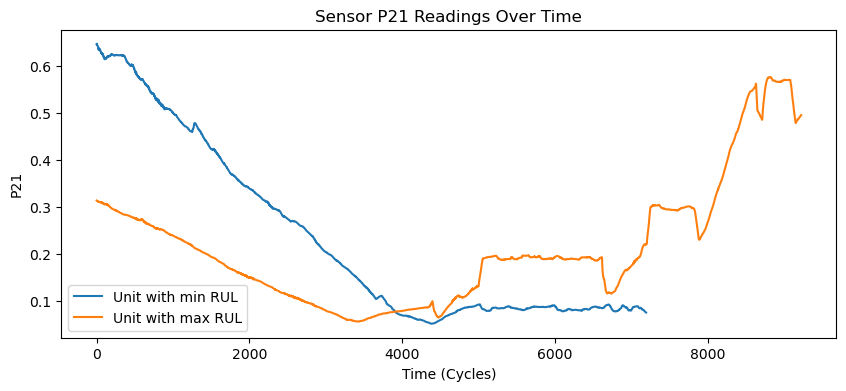

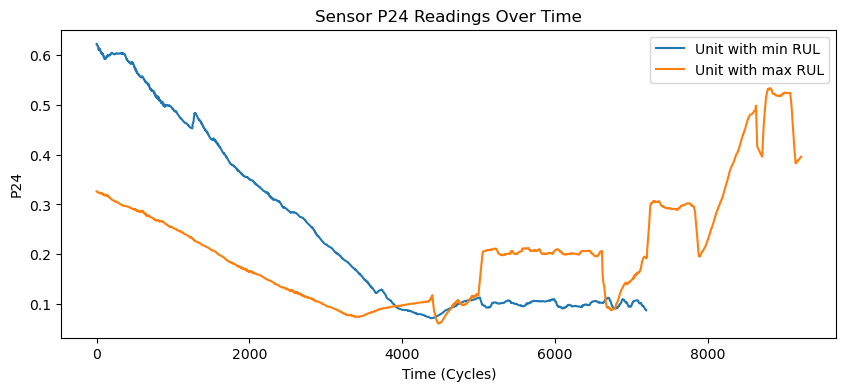

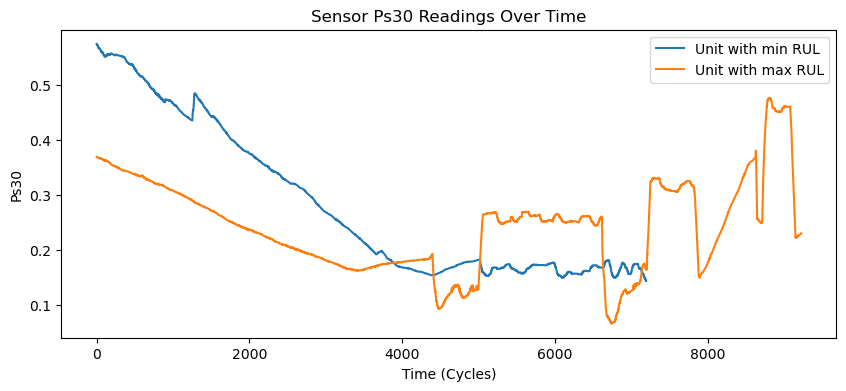

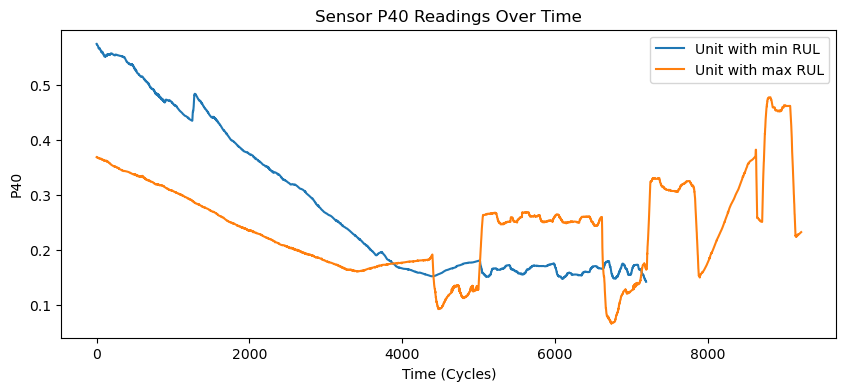

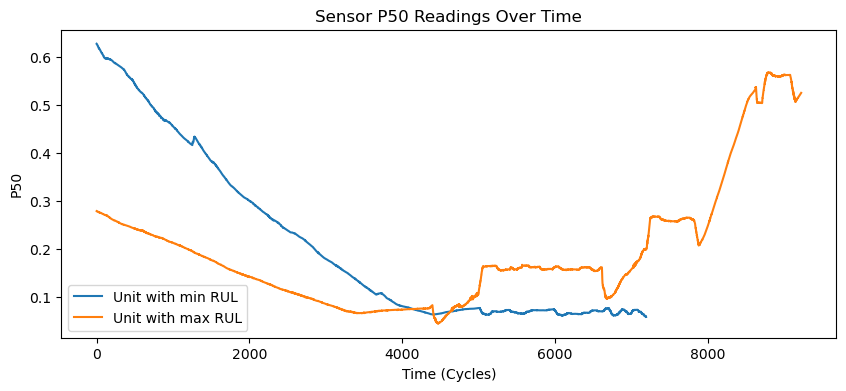

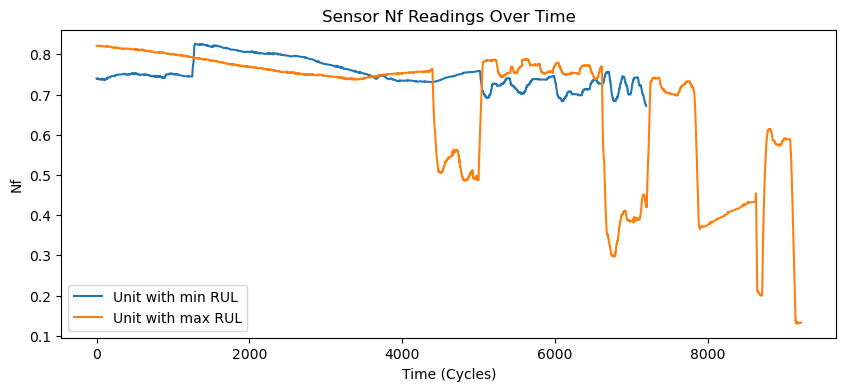

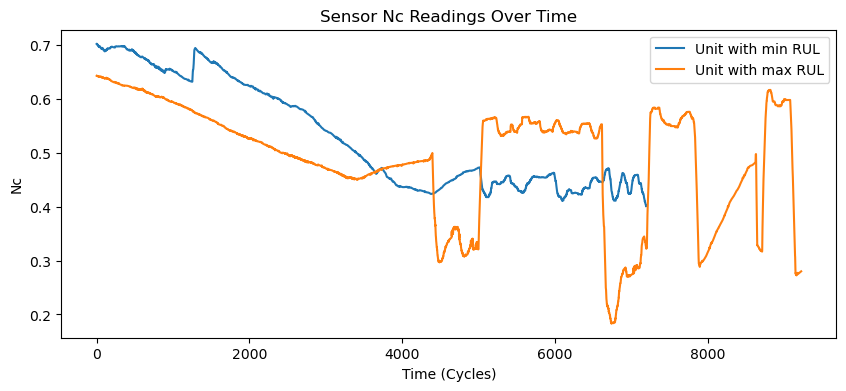

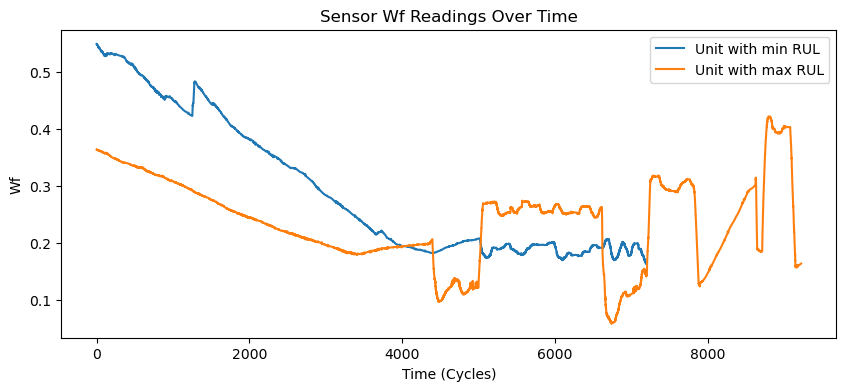

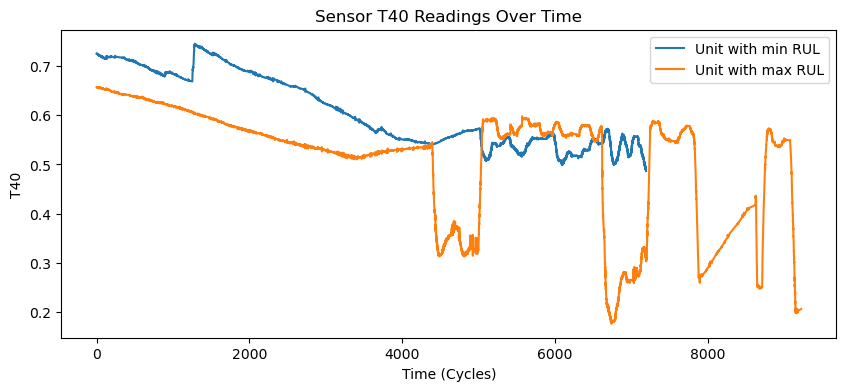

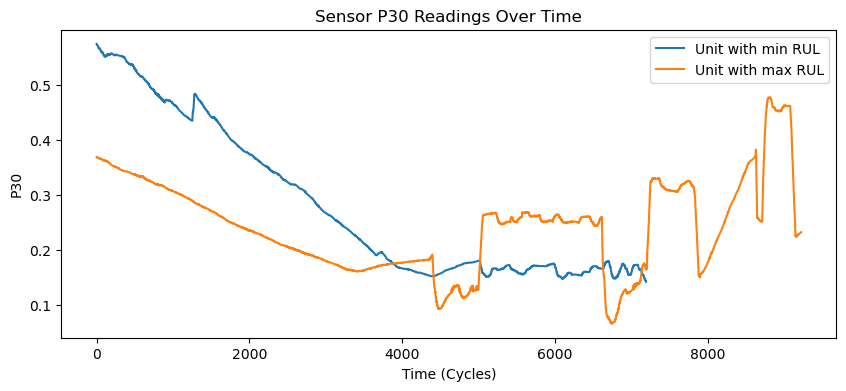

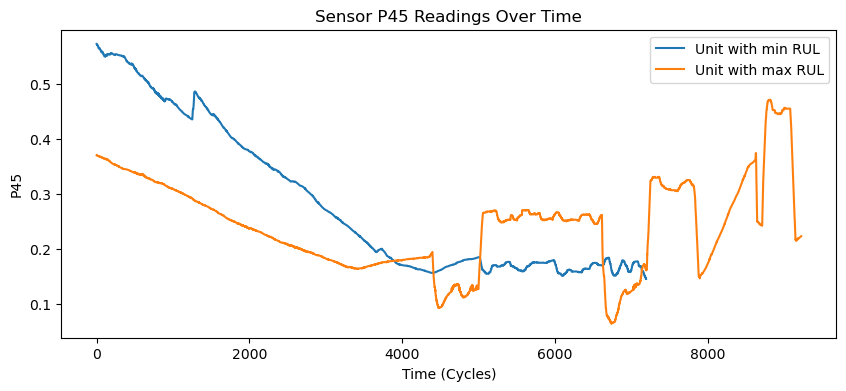

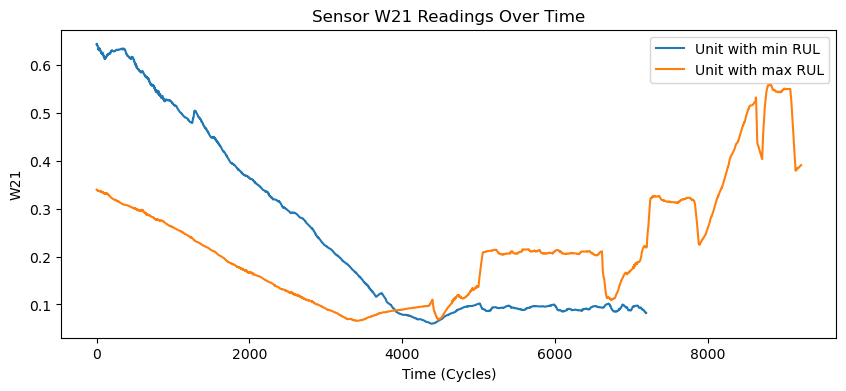

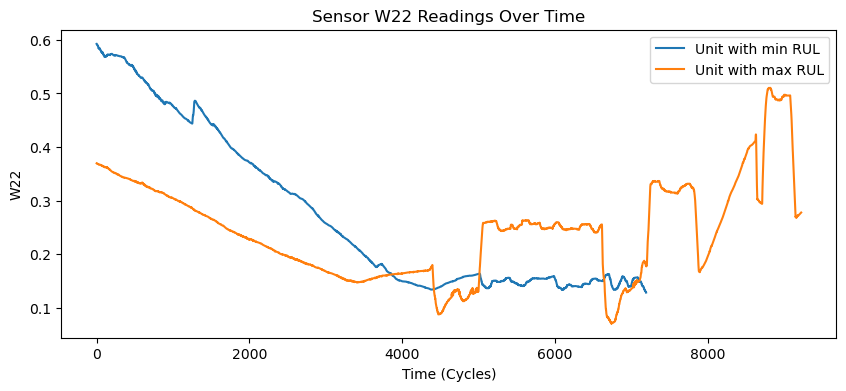

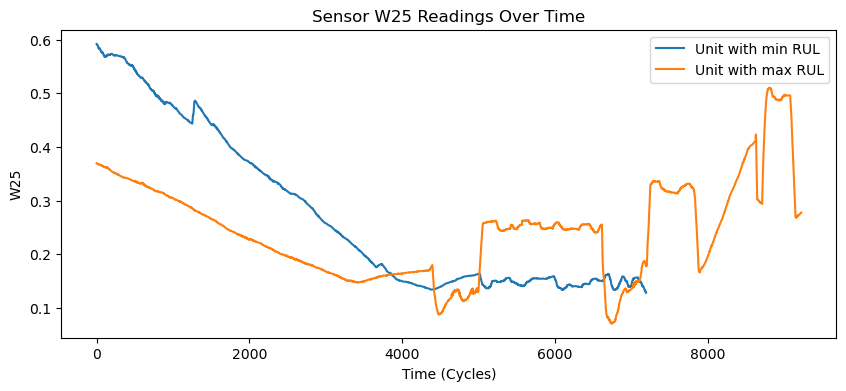

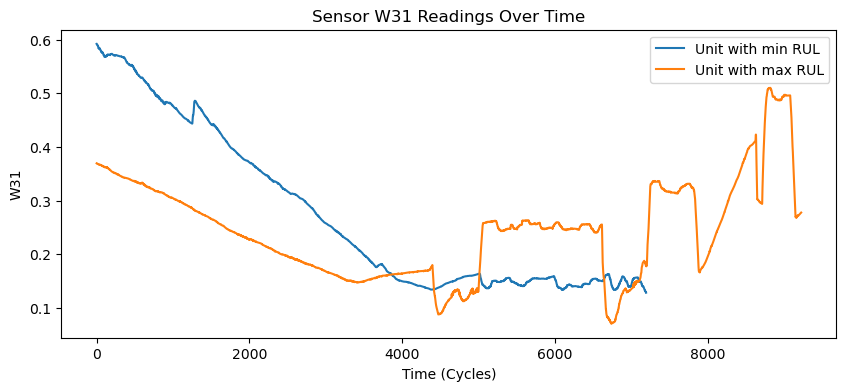

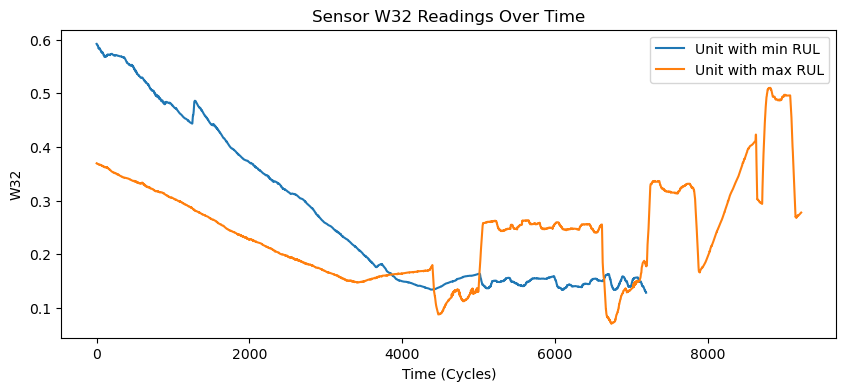

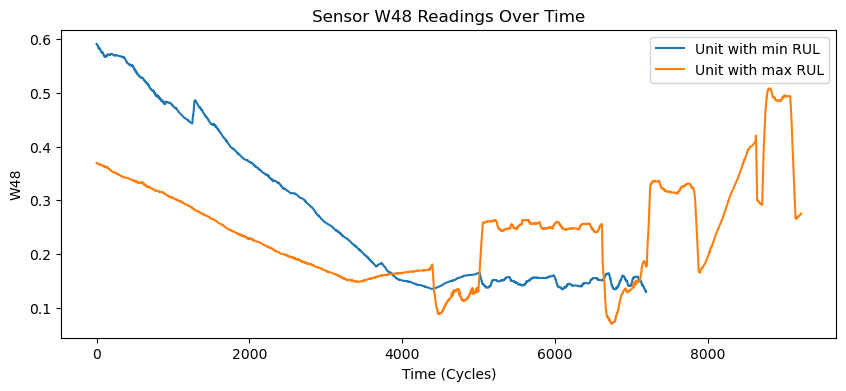

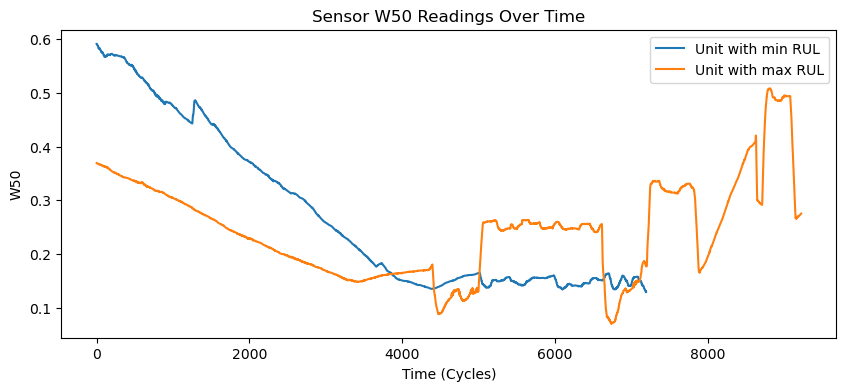

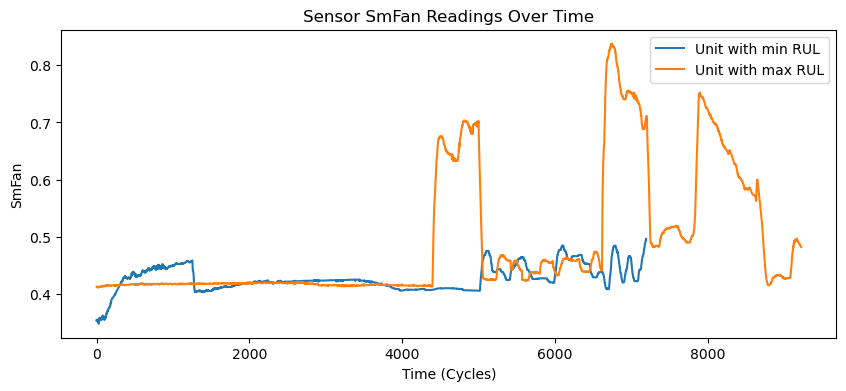

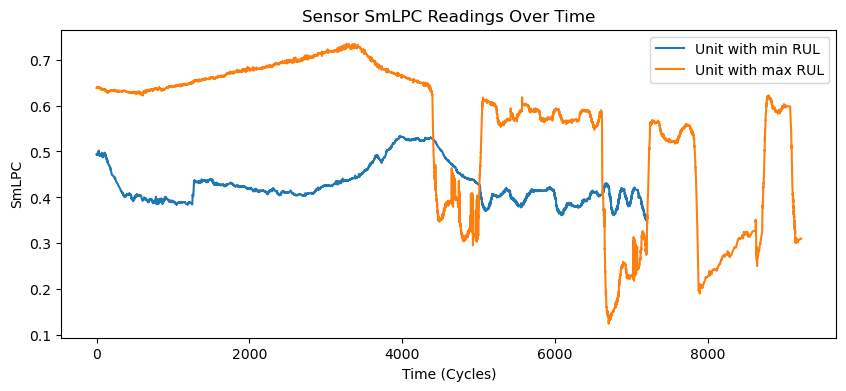

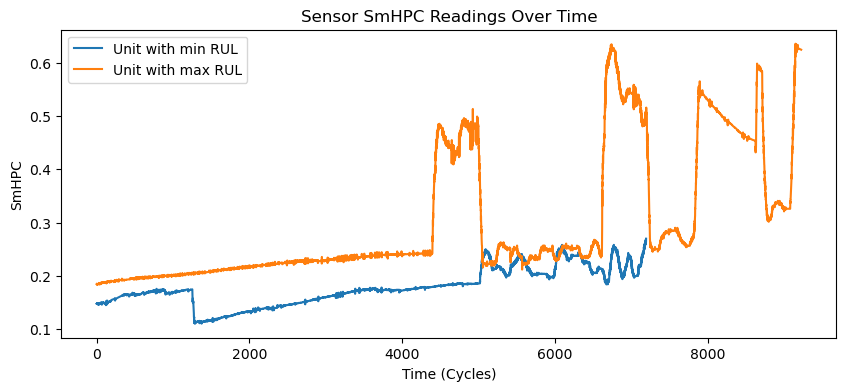

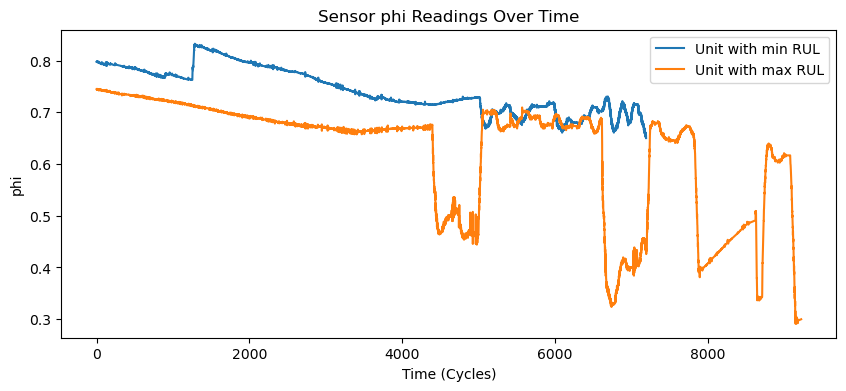

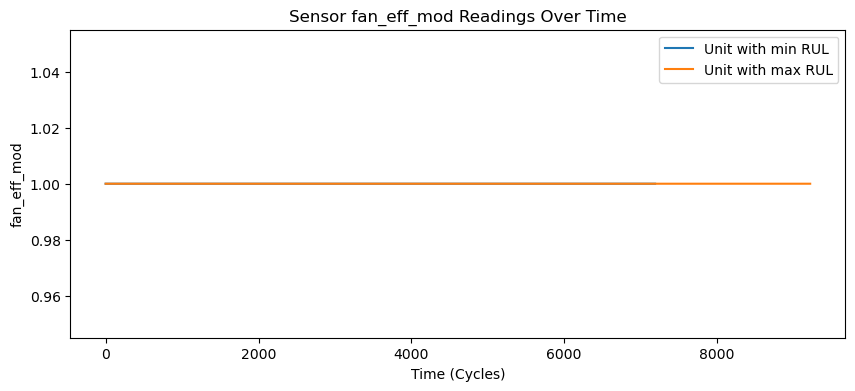

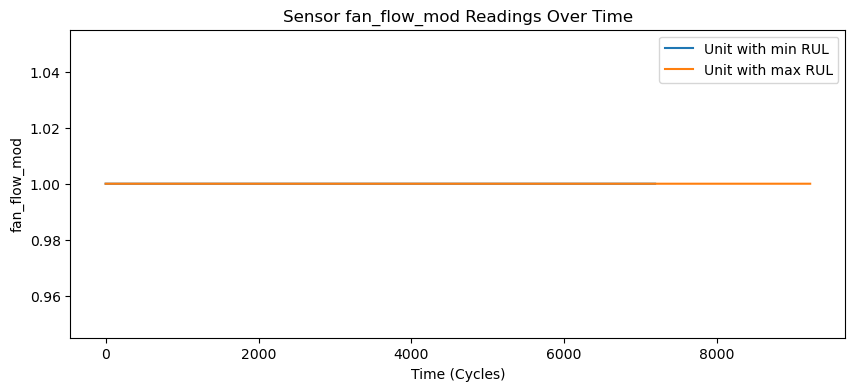

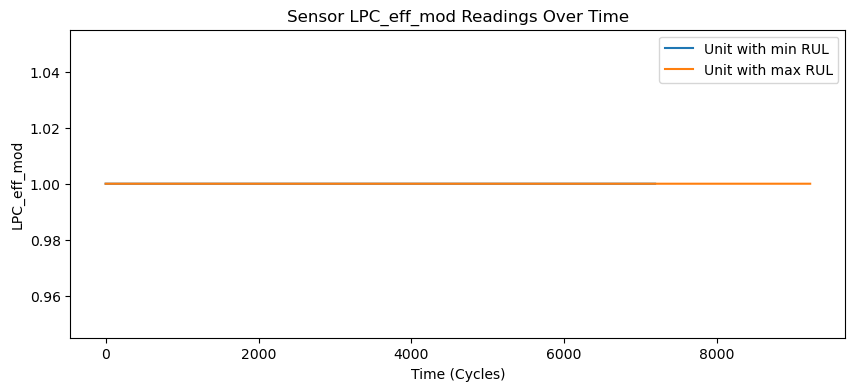

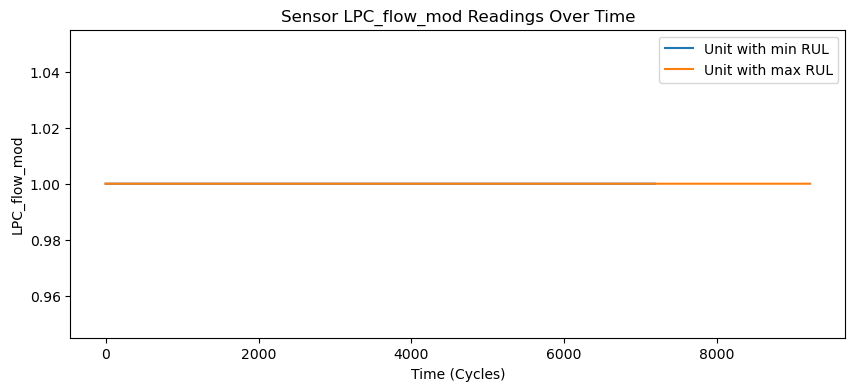

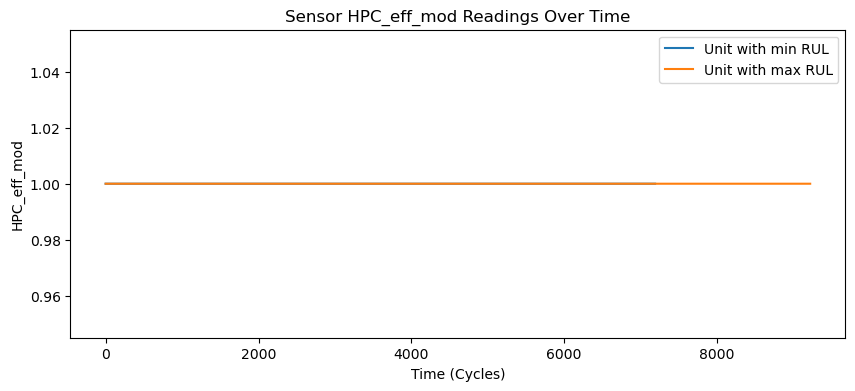

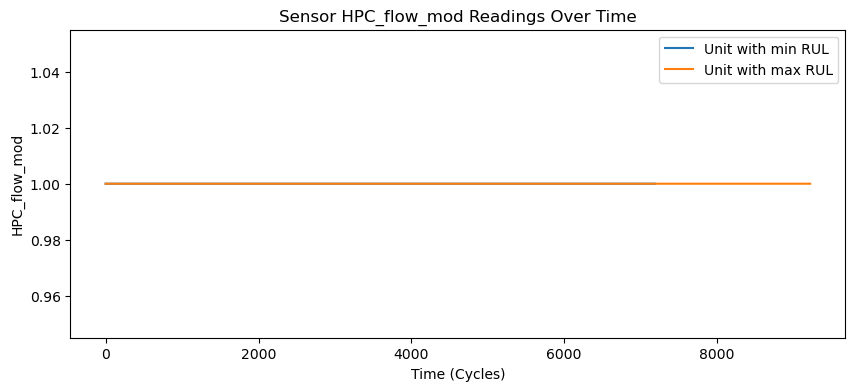

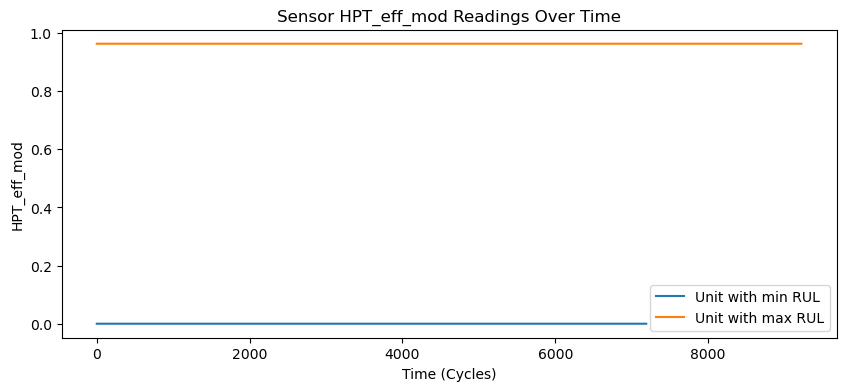

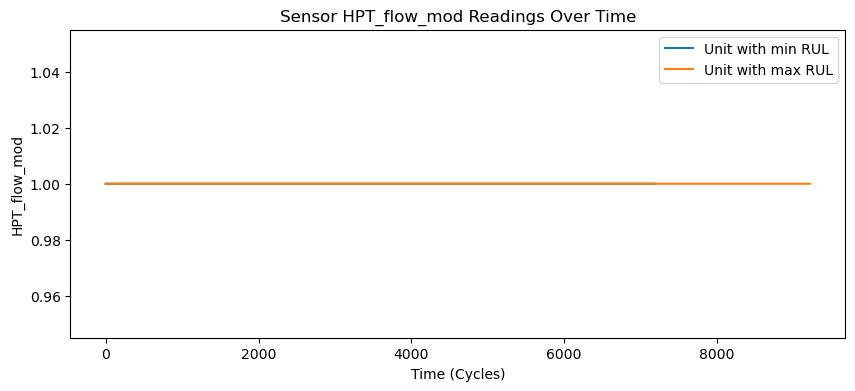

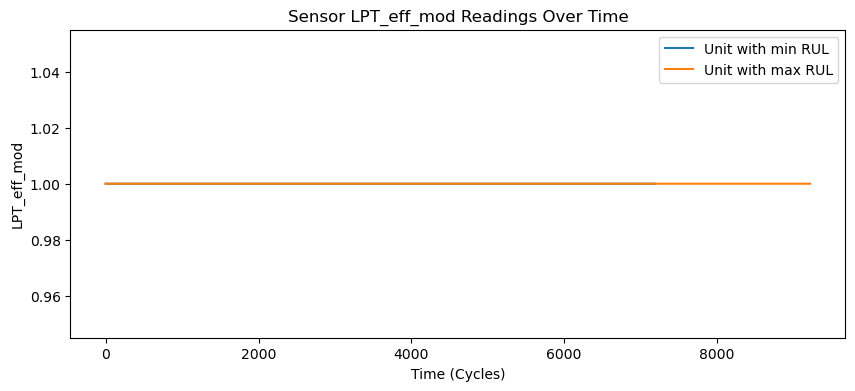

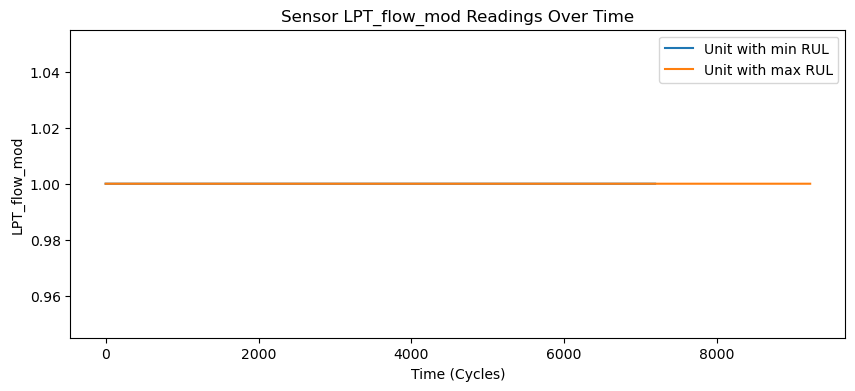

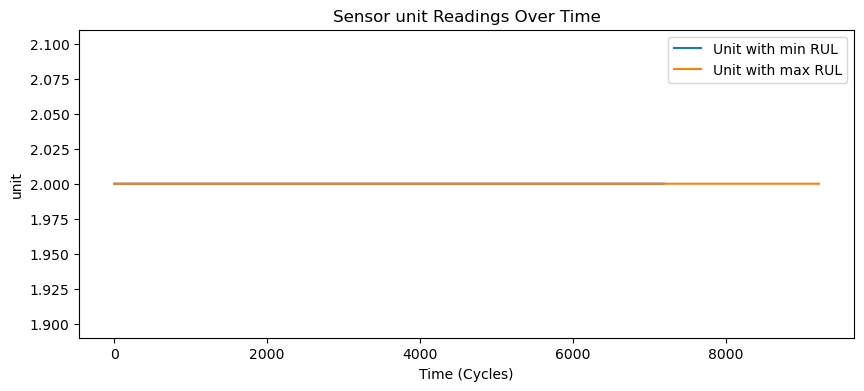

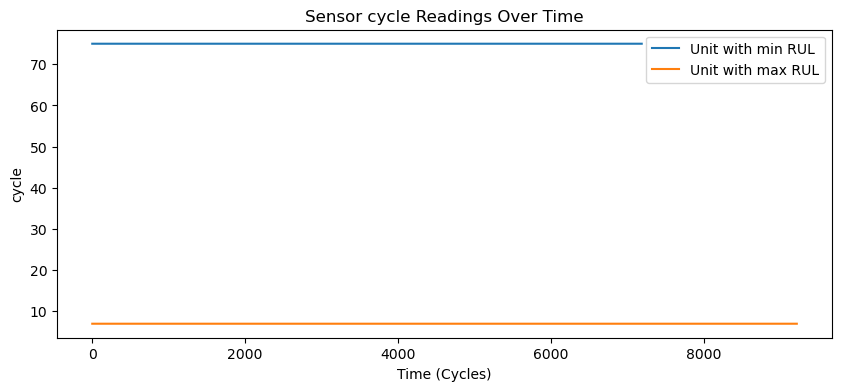

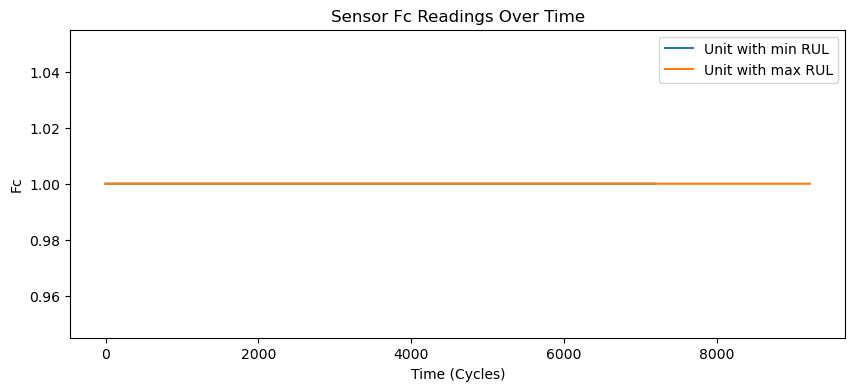

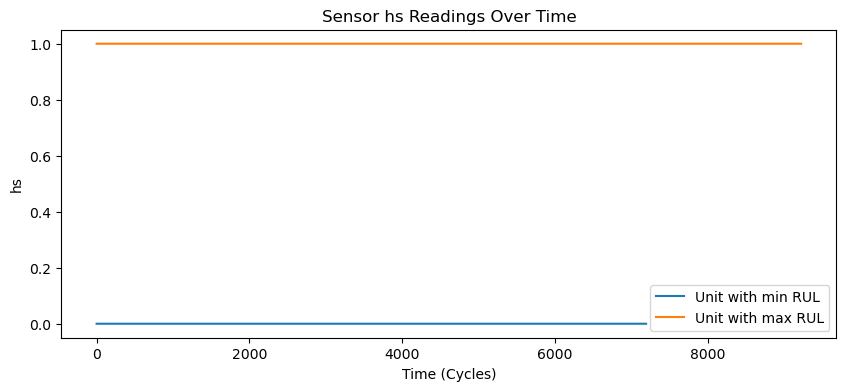

In [12]:
unit = df["unit"].unique()[0]
unit_df = df[df["unit"] == unit]
for sensor in cols:
    plt.figure(figsize=(10, 4))
    min_max_rul_cycles = {"min": unit_df.loc[unit_df['RUL'].idxmin()]['cycle'], "max": unit_df.loc[unit_df['RUL'].idxmax()]['cycle']}
    for title, cycle in min_max_rul_cycles.items():  
        subset = unit_df[unit_df["cycle"] == cycle]
        plt.plot(list(range(len(subset))), subset[sensor], label=f"Unit with {title} RUL")
    plt.title(f"Sensor {sensor} Readings Over Time")
    plt.xlabel("Time (Cycles)")
    plt.ylabel(sensor)
    plt.legend()
    plt.show()

#### Correlation Among Sensors
There is massive correlation among most of the sensors. This makes sense for some of them. For example, the W features all have to do with Fan Flow. 

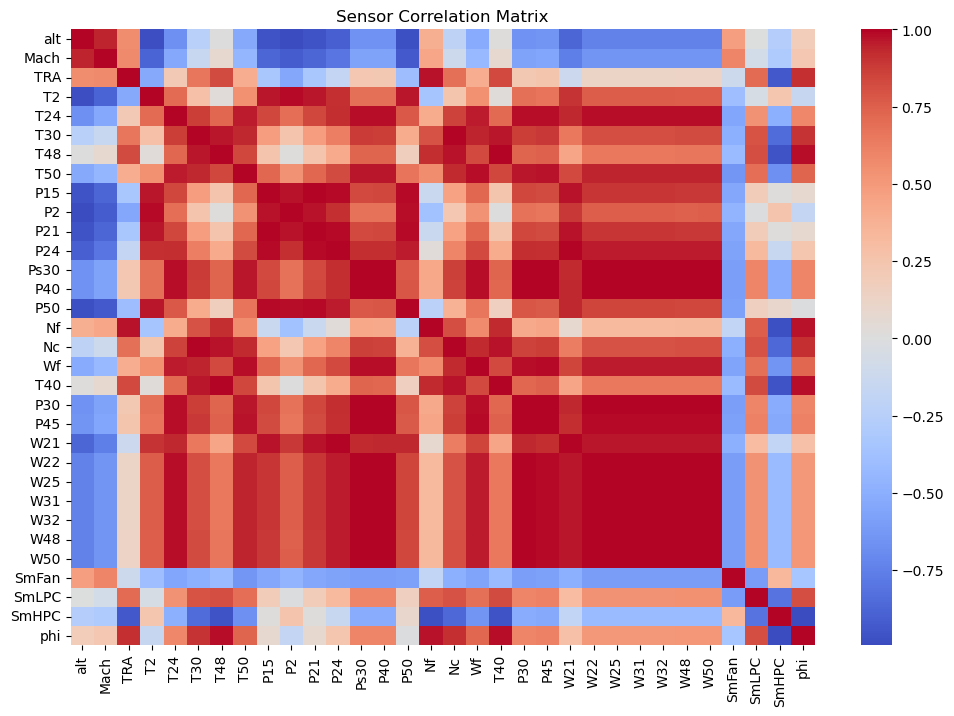

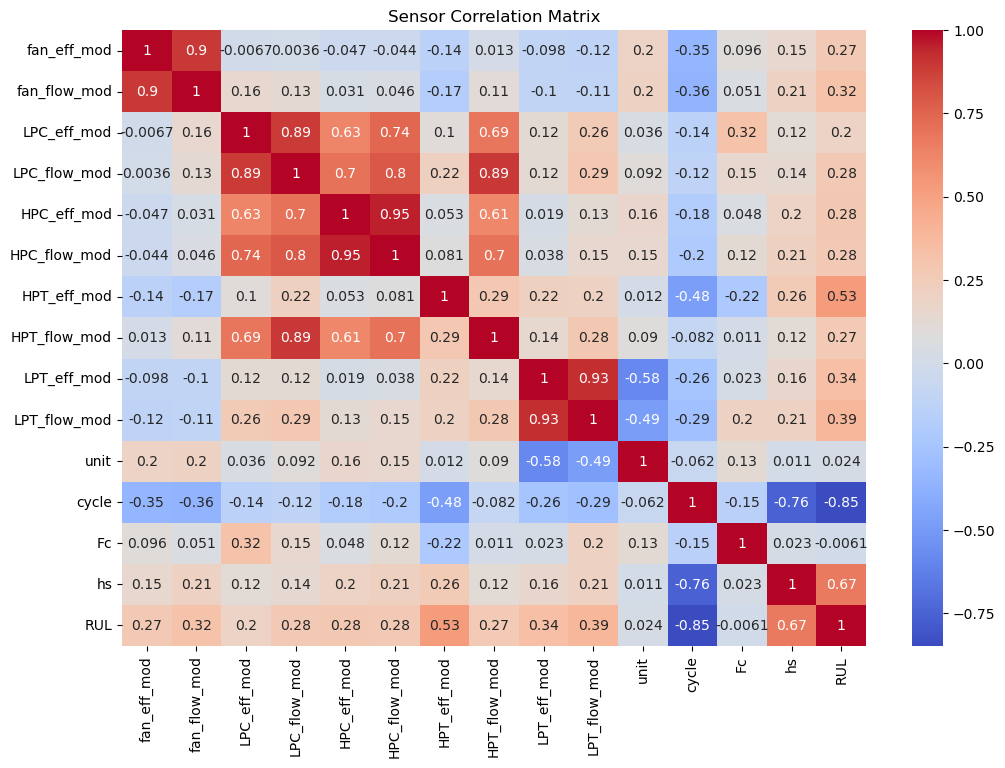

In [13]:
corr_matrix = df[df.columns[:32]].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm")
plt.title("Sensor Correlation Matrix")
plt.show()
corr_matrix = df[df.columns[32:]].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True)
plt.title("Sensor Correlation Matrix")
plt.show()

In [13]:
df.groupby(['unit','cycle']).size().reset_index().rename(columns={0:'count'})

unit  cycle  count
0    1.0   47.0  12145
1    1.0   56.0   4997
2    1.0   57.0   9812
3    1.0   58.0   3675
4    2.0    1.0  12580
..   ...    ...    ...
58   8.0   62.0   3750
59  10.0   54.0  10557
60  10.0   82.0   5690
61  16.0    1.0   3757
62  20.0   41.0  10723

[63 rows x 3 columns]

# Convolutional Feature Extraction
Because this is time series data, it is useful to do EDA on time windows rather than individual observations.
#### Extract Time Series Windows

In [14]:
def create_time_windows(df, window_size=50, feature_cols=None, target_col="RUL", id_cols=["unit"]):
    if feature_cols is None:
        feature_cols = [col for col in df.columns if col not in id_cols + ["time", target_col]]

    X, y = [], []
    
    # Group by the identifier columns to ensure windows do not span multiple time series
    grouped = df.groupby(id_cols).size().reset_index().rename(columns={0:'count'})
    
    # for each time series
    for i in range(len(grouped)):
        subset = df
        for col in id_cols:
            subset = subset[subset[col] == grouped[col][i]]
        # for each window within the series (should be # obsvervations - window size for each series)
        for i in range(len(subset) - window_size):
            X.append(subset.iloc[i:i+window_size][feature_cols].values)
            y.append(subset.iloc[i+window_size][target_col])

    return np.array(X), np.array(y)

def save_to_hdf5(X, y, filename="data.h5"):
    with h5py.File(filename, "w") as f:
        f.create_dataset("X", data=X, compression="gzip")
        f.create_dataset("y", data=y, compression="gzip")

def load_from_hdf5(filename="data.h5"):
    with h5py.File(filename, "r") as f:
        X = f["X"][:]
        y = f["y"][:]
    return X, y


In [15]:
X, y = create_time_windows(df, window_size=50, target_col="RUL", id_cols=["unit", "cycle"])

In [16]:
save_to_hdf5(X, y, "sample_windows.h5")

In [17]:
X, y = load_from_hdf5(filename="sample_windows.h5")

#### Independent Convolutional Feature Extraction
Looking at the data as individual observations can only tell us so much about how the data behaives temporally. Instead, we can reformat the data as windows of time where each X y mapping is a matrix of some number of observations being mapped to a RUL value. This will better reflect how the data will actually be input into the ultimate CNN. It can reveal patterns in the data that cannot be gleaned from individual observations. 

In [18]:
def conv_feat_extract(X, filters):
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Convert input to PyTorch tensor
    X_tensor = X_tensor.permute(0, 2, 1)  # Change shape to (batch, channels, time_steps)

    num_filters = len(filters)
    X_conv = torch.zeros((X_tensor.shape[0], X_tensor.shape[1], X_tensor.shape[2], num_filters))

    with torch.no_grad():
        for i, kernel in enumerate(filters):
            kernel_tensor = torch.tensor(kernel, dtype=torch.float32).view(1, 1, -1)  # (out_channels, in_channels, kernel_size)
            conv_layer = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=len(kernel), padding="same", bias=False)
            conv_layer.weight.data = kernel_tensor  # Manually set filter weights
            print("starting filter")

            # convolve over features independently, ignore feature interactions for now.
            for feature in range(X_tensor.shape[1]):  # Apply convolution per feature
                X_conv[:, feature, :, i] = conv_layer(X_tensor[:, feature:feature+1, :]).squeeze(1)
            print("filter done")

    return X_conv.detach().numpy()

We will not train and kernel yet. We can instead use a few well known kernels for feature extraction.

In [19]:
smoothing_filter = np.array([1/3, 1/3, 1/3])  
edge_detection_filter = np.array([-1, 0, 1]) 
# https://medium.com/@rajilini/laplacian-of-gaussian-filter-log-for-image-processing-c2d1659d5d2
trend_detection_filter = np.array([1, -2, 1])  
filters = [smoothing_filter, edge_detection_filter, trend_detection_filter]

In [20]:
# Apply Convolutional Feature Extraction using PyTorch
X_conv = conv_feat_extract(X, filters)  # Shape: (samples, time_steps, features, num_filters)
# Flatten the output for EDA analysis
X_flat = X_conv.reshape(X_conv.shape[0], -1)

starting filter
filter done
starting filter
filter done
starting filter
filter done
before flattening


starting pca


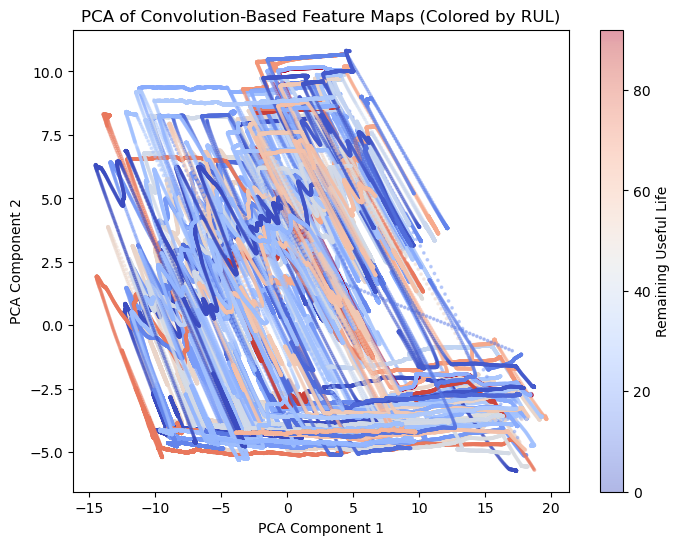

In [21]:
# PCA for feature visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="coolwarm", alpha=0.4, s=3)
plt.colorbar(label="Remaining Useful Life")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Convolution-Based Feature Maps (Colored by RUL)")
plt.show()

In [24]:
from sklearn.manifold import TSNE

In [35]:
# take a subsample of X and y bc t-sne is memory and computationally very intensive
idxs = np.random.choice(X_flat.shape[0], size=100000, replace=False)
X_mini = X_flat[idxs]
y_mini = y[idxs]

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_mini)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
X_tsne = tsne.fit_transform(X_pca)



(100000, 6600)


/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.019s...
[t-SNE] Computed neighbors for 100000 samples in 180.890s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional prob

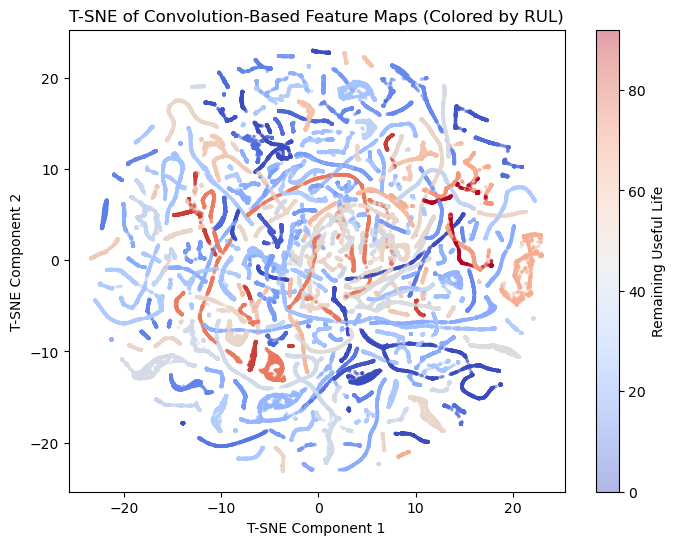

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_mini, cmap="coolwarm", alpha=0.4, s=3)
plt.colorbar(label="Remaining Useful Life")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.title("T-SNE of Convolution-Based Feature Maps (Colored by RUL)")
plt.show()

It's a bit hard to note any pattern in the data reduced with PCA. For the data reduced with T-SNE, it appears that observation windows with more remaining useful life tend to be in the center to the mid upper right. 

#### Non Independent Convolutional Feature Extraction
Previously, we comvolved over features one at a time. This does not capture interactions among features, so we will next convolve over features collectively. It is important to order the feaures correctly here. If features that interact are not ordered beside one another, their interactions will not be captured. So we will try ordering the features by their correlations

In [40]:
import scipy.cluster.hierarchy as sch

def order_by_corr(X):
     # Compute correlation matrix across features
    X_reshaped = X.reshape(-1, X.shape[-1])  # Collapse samples and time to compute correlations
    corr_matrix = np.corrcoef(X_reshaped, rowvar=False)

    # Perform hierarchical clustering
    linkage = sch.linkage(corr_matrix, method="ward")
    dendro = sch.dendrogram(linkage, no_plot=True)
    feature_order = dendro["leaves"]  # Get new feature order

    # Reorder features
    X_reordered = X[:, :, feature_order]

    return X_reordered, feature_order

def grouped_conv(X, groups):
    X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 2, 1)  # (batch, features, time_steps)
    X_conv = torch.zeros_like(X_tensor)  # Same shape to store results

    with torch.no_grad():
        for group in groups:
            if len(group) < 2:
                continue  # Skip groups with a single feature

            # Apply 1D convolution across the grouped features
            conv_layer = nn.Conv1d(in_channels=len(group), out_channels=len(group), kernel_size=3, padding="same", groups=len(group), bias=False)
            X_conv[:, group, :] = conv_layer(X_tensor[:, group, :])
    

    return X_conv.permute(0, 2, 1).numpy()

In [41]:
# Reorder features based on correlation
X_reordered, feature_order = order_by_corr(X)
print(X_reordered.shape)



(436221, 50, 44)


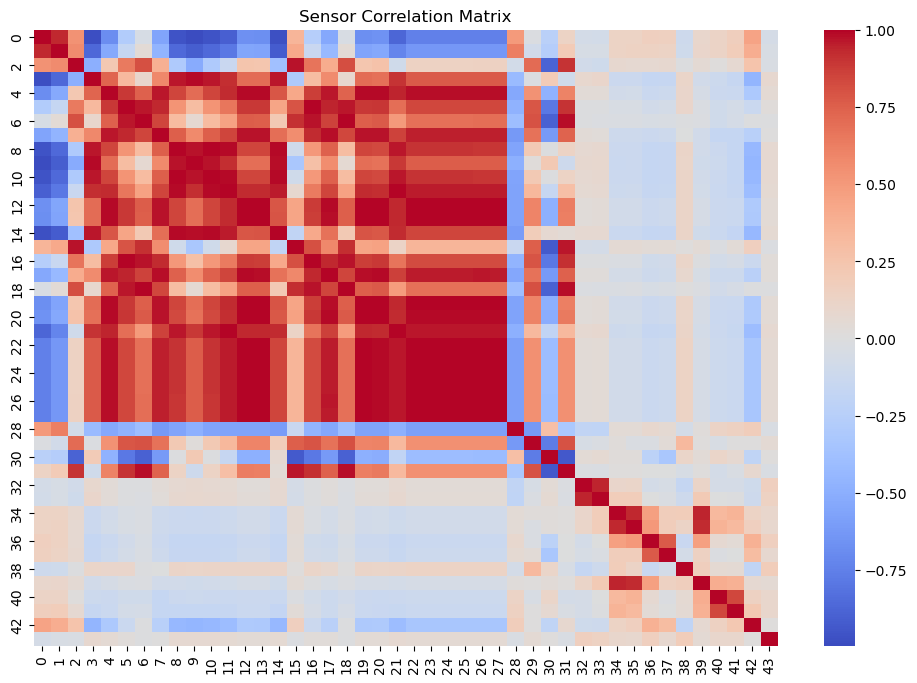

In [42]:
# corr marix to identify groups
X_reshaped = X.reshape(-1, X.shape[-1])  # Collapse samples and time to compute correlations
corr_matrix = np.corrcoef(X_reshaped, rowvar=False)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm")
plt.title("Sensor Correlation Matrix")
plt.show()

In [43]:
groups = [[0, 1, 2], list(range(3, 28)), [28, 29, 30, 31], [32, 33], [34, 35], [36, 37], [38], [39], [40, 41], [42], [43]]

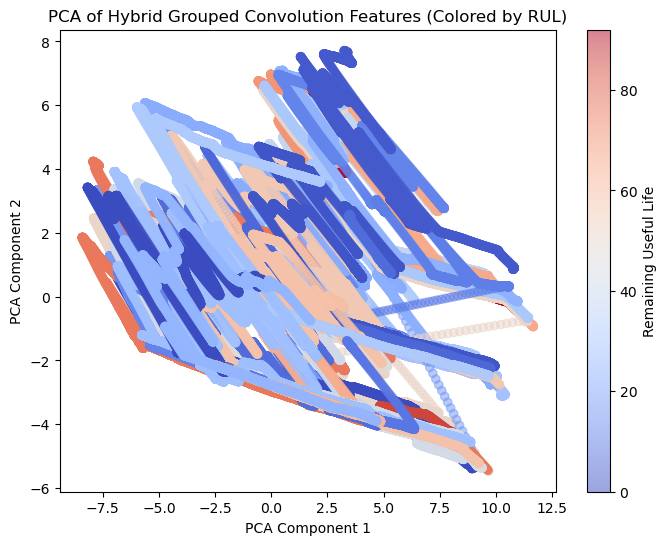

In [44]:
# Apply Hybrid Grouped Convolutions
X_grouped_conv = grouped_conv(X_reordered, groups)

# Flatten for PCA
X_flat = X_grouped_conv.reshape(X_grouped_conv.shape[0], -1)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

# Scatter plot of PCA components colored by RUL
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="coolwarm", alpha=0.5, s=3)
plt.colorbar(label="Remaining Useful Life")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Hybrid Grouped Convolution Features (Colored by RUL)")
plt.show()

In [45]:
# take a subsample of X and y bc t-sne is memory and computationally very intensive
idxs = np.random.choice(X_flat.shape[0], size=100000, replace=False)
X_mini = X_flat[idxs]
y_mini = y[idxs]

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_mini)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
X_tsne = tsne.fit_transform(X_pca)

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.012s...
[t-SNE] Computed neighbors for 100000 samples in 188.380s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional prob

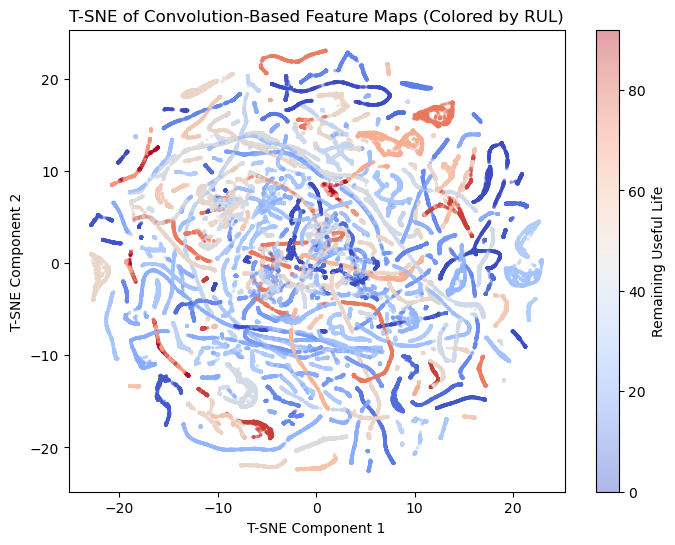

In [46]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_mini, cmap="coolwarm", alpha=0.4, s=3)
plt.colorbar(label="Remaining Useful Life")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.title("T-SNE of Convolution-Based Feature Maps (Colored by RUL)")
plt.show()